# ch05.11. 사이킷런 실습 - 분류모델 탐색
---
* 날짜:
* 이름:

## 학습내용
    - 소프트맥스 회귀 프로세스를 이해한다.
    - 소프트맥스 함수를 구현한다.

## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 3장. 사이킷런을 타고 떠나는 머신 러닝 분류 모델 투어
- [sckitlearn [1.12. Multiclass and multioutput algorithms]](https://scikit-learn.org/stable/modules/multiclass.html)

```
import numpy as np
import matplotlib.pyplot as plt
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### **데이터 준비 : Iris**

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

def iris_loader(n_classes, #클래스 개수 지정(2-이진, 3-다종)
                features='',#특징선택 (0 또는 1:sapal 길이/너비 2가지 3가지:petal 길이/너비)
                test_size=0.2, #데이터 분할 때 테스트 사이즈
                rs=1, #데이터 분할 시 랜덤시드
                scale=True): #스케일 여부
  
  iris = load_iris()
  X = iris.data # (n,4)
  y = iris.target # (n,) y값은 0,1,2  3가지가 있다
  columns = iris.feature_names #{특징1,특징2, 특징3, 특징4}
  labels = iris.target_names # 꽃 종류 {1번꽃 2번꽃 3번꽃}
  
  # 클래스 개수 지정
  if n_classes == 2: #이진 분류 -> X(0,1,2 가 있음),y중에서 y가 2가 아닌 데이터
    mask = y!=2
    X = X[mask]
    y = y[mask]
    labels = labels[:2]
  else: pass #2가 아닐땐 원본 데이터(3가지 종류)
  # 특징 지정
  if features == 'sepal':
    X = X[: , :2]
    columns = columns[:2]
  elif features == 'petal':
    X = X[: , 2:]
    columns = columns[2:]
  else : pass

  # 데이터 분할
  X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                     test_size=test_size, 
                                                     random_state=rs)
  # 스케일링(X에만)
  if scale : # 스케일 -> True/False
    sc_x = StandardScaler()
    X_train = sc_x.fit_transform(X_train)
    X_test = sc_x.transform(X_test)
  

  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, features, labels)
  return X_train, X_test, y_train, y_test, columns, labels

In [3]:
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


## 회귀모델
---



<p align='center'>
<img src=https://camo.githubusercontent.com/c4c08b5281e9a087e3db007b8bf2baaca4b64b8cc8f109e59439be7b3a9694ed/68747470733a2f2f6769742e696f2f4a746d3232?raw=true width=520>
</p>

### | 사이킷런을 이용한 구현
[사이킷런 - LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression)
```
linear_model.LogisticRegression(penalty='l2', #가중치 규제(마치 lasso에서 정규화항 같은 거 l2가 디폴트값)
                                dual=False, # 가중치 규제 강도
                                tol=0.0001, 
                                C=1.0, 
                                fit_intercept=True, #편향 추가
                                intercept_scaling=1,
                                class_weight=None,
                                random_state=None, 
                                solver='lbfgs',  #최적화 종류 선택(경사하강법같은거)
                                max_iter=100, 
                                multi_class='auto', 
                                verbose=0, 
                                warm_start=False, 
                                n_jobs=None, 
                                l1_ratio=None)
# 하이퍼파라미터들
```


* 작은 데이터 세트의 경우 `liblinear`가 좋은 선택인 반면, 큰 데이터 세트의 경우 `sag`와 `saga`가 더 빠릅니다.

* 다중 클래스 문제의 경우 `newton-cg`, `sag`, `saga` 및 `lbfgs`만 다항 손실을 처리합니다.

* 알고리즘 별 패털티 선택 가이드 라인
  * `newton-cg` : [‘l2’, ‘none’]
  * `lbfgs` : [‘l2’, ‘none’]
  * `liblinear` : [‘l1’, ‘l2’]
  * `sag` : [‘l2’, ‘none’]
  * `saga` : [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]


### **| 이진분류**

* 'sepal' 관련 특성을 이용하여 'setosa', 'versicolor' 두 종류 구분
* 최적화 방식 `liblinear` 사용

In [4]:
from sklearn.linear_model import LogisticRegression

# 데이터로드
X_train, X_test, y_train, y_test, columns, labels = iris_loader(2, 'sepal')

# 모델학습
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# 성능평가(분류:accuracy)
print('Acc:', model.score(X_test, y_test))

(80, 2) (20, 2) (80,) (20,) sepal ['setosa' 'versicolor']
Acc: 1.0


#### **혼돈행렬**

* 함수 구현

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def draw_cm(model, X, y, title=''):    
  y_pred = model.predict(X)
  cm = confusion_matrix(y, y_pred) # 혼돈 행렬 구하기
  ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues')
  if title:plt.title(title)
# cm은 맞춘 개수 

* 혼돈 행렬 시각화

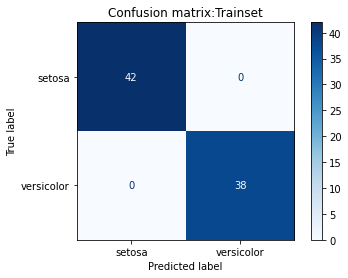

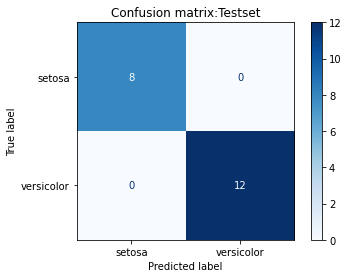

In [6]:
draw_cm(model, X_train, y_train, 'Confusion matrix:Trainset')
plt.show()
draw_cm(model, X_test, y_test, 'Confusion matrix:Testset')
plt.show()

* 예측 오차 (ERR)

\begin{split}
ERR = \frac{잘못된 예측 개수}{전체 샘플 개수}
\end{split}

In [7]:
err = (0 + 0) / 20
err

0.0

* 예측 정확도 (ACC)

\begin{split}
ACC = \frac{잘된 예측 개수}{전체 샘플 개수} = 1-ERR
\end{split}

In [8]:
acc = (8 + 12) / 20
acc

1.0

#### **결정경계**

In [9]:
from matplotlib.colors import ListedColormap

def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[]): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_set.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  plt.legend()

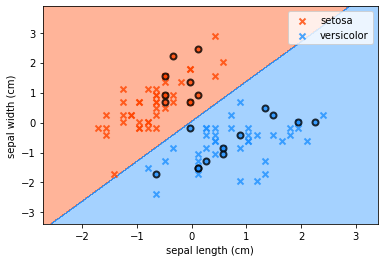

In [10]:
draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)

### **| 다중클래스 분류**

* `sepal` 관련 특성을 이용하여 3개 클래스 분류
* 최적화 방식 `lbfgs` 사용
* `multi_class`는 `multi_nomial`로 지정
* 정확도 출력
* 혼돈 행렬 시각화
* 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


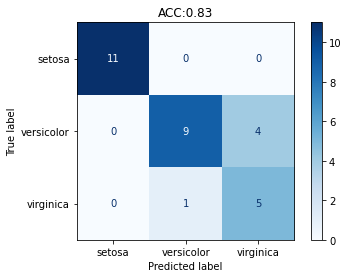

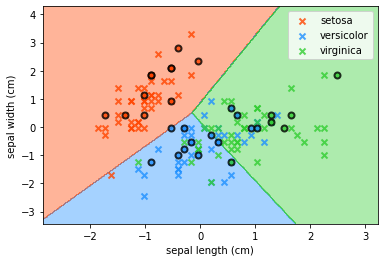

In [11]:
from sklearn.linear_model import LogisticRegression

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')

# 학습
model = LogisticRegression(solver='lbfgs',
                           multi_class='multinomial')
model.fit(X_train, y_train)

# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
plt.show()

# 결정경계 시각화
draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
plt.show()

#### **예제 01**

* 'petal' 관련 특성을 이용하여 3개 클래스 분류
* 모델
  * 최적화 방식 `saga` 사용
  * `multi_class`는 `multi_nomial`로 지정
* 평가
  * 정확도 출력
  * 혼돈 행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


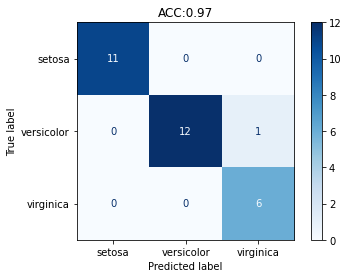

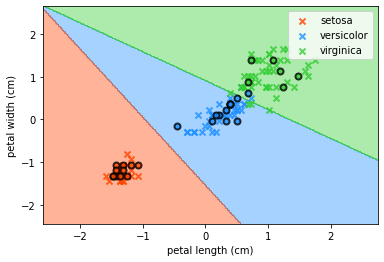

In [12]:
from sklearn.linear_model import LogisticRegression

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')

# 학습
model = LogisticRegression(solver='saga',
                           multi_class='multinomial')
model.fit(X_train, y_train)

# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
plt.show()

# 결정경계 시각화
draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
plt.show()

#### **예제 02**

* 모든 특성(4개)을 이용하여 3개 클래스 분류
* 모델
  * 최적화 방식 `lbfgs` 사용
  * `multi_class`는 `multi_nomial`로 지정
* 평가
  * 정확도 출력
  * 혼돈 행렬 시각화

(120, 4) (30, 4) (120,) (30,)  ['setosa' 'versicolor' 'virginica']


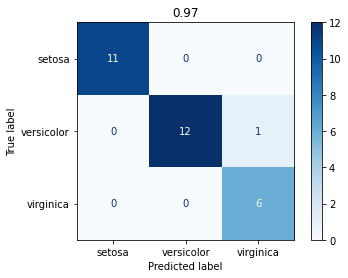

In [13]:
#데이터
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3)

#모델학습
model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)

#정확도, 혼돈행렬
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=np.round(acc,2))

## 결정트리 (Decision tree)
---

<p align='center'>
<img src=https://camo.githubusercontent.com/436f5e942773563b85e5d640e5714c367e11cf08edc9da5b41598ab7dea951c9/68747470733a2f2f6769742e696f2f4a746d3231
?raw=true width=600>
</p>

훈련 데이터의 특성(속성)을 기반으로 샘플의 클래스 레이블을 추정할 수 있는 일련의 질문을 학습

데이터의 특성이 범주형이 아니라 실수라면 특정 값을 기준으로 크고 작음의 범주로 나누게 된다.

데이터 분할 기준은 정보이득 (Information Gain, IG)의  최대화이며, 정보이득은 불순도로 부터 구해진다.

불순도(Impurity) 란 특정 영역 내에 클래스가 얼마나 섞여있는지를 나타내는 지표

리프 노드(leaf node)가 순수해질 때까지 모든 자식 노드에서 분할 작업을 반복한다.

너무 많은, 깊은 트리가 만들어 지면 과적합의 가능성이 높아지기 때문에 트리의 최대 깊이를 제한하여 트리를 가지치기(pruning) 한다.






### **| 불순도 지표: 엔트로피(Entropy)**

\begin{split}
I_H(t) = -\sum_{i=1}^{c}p(i|t)log_2p(i|t)
\end{split}

* $p(i|t)$ : 특정노드 t에 클래스 i에 속한 샘플의 확률(=비율)
* $I_H$ 의 범위 : 0-1
* $I_H = 1 $: 
* $I_H = 0 $: 
* 불순도(엔트로피) 낮을수록 좋다?


In [14]:
# 이진 분류
def entropy(p): #p는 0-1
  return - p * np.log2(p) - (1-p) * np.log2(1-p)

In [15]:
p = np.arange(0.01, 1, 0.1)
entropy(p)

array([0.08079314, 0.49991596, 0.74148274, 0.89317346, 0.97650047,
       0.99971144, 0.96479955, 0.86872125, 0.70147146, 0.43646982])

![](https://github.com/yebiny/Lecture-Deeplearning/blob/main/imgs/bdt_%EB%B6%88%EC%88%9C%EB%8F%84.PNG?raw=true)

### **| 불순도 지표: 지니 불순도(Gini impurity, $I_G$)**

\begin{split}
I_G(t) = \sum_{i=1}^{c}p(i|t)(1-p(i|t)) 
\end{split}

* $p(i|t)$ : 0부터 1의 확률
* $I_G$ 의 범위 : 0부터 0.5
* $I_G = 0.5 $: 클래스가 균등하게 존재
* $I_G = 0 $: 클래스가 한쪽에 치우쳐 존재
* 불순도(지니)가 낮을 수록 그 영역에 한 클래스가 우세


In [16]:
def gini(p):
  return p*(1-p) + (1-p) * (1-(1-p))

In [17]:
p = np.arange(0.01, 1, 0.1)
gini(p)

array([0.0198, 0.1958, 0.3318, 0.4278, 0.4838, 0.4998, 0.4758, 0.4118,
       0.3078, 0.1638])

### **| 불순도 지표: 분류 오차(Classification error, $I_E$)**

\begin{split}
I_H(E) = 1-max\{p(i|t)\} 
\end{split}




In [18]:
def error(p):
  return 1-np.max([p, 1-p]) #첫번째 클래스 두번째 클래스 중에 큰거

In [19]:
[error(pi) for pi in p]

[0.010000000000000009,
 0.10999999999999999,
 0.20999999999999996,
 0.31000000000000005,
 0.41000000000000003,
 0.49,
 0.3899999999999999,
 0.2899999999999999,
 0.18999999999999995,
 0.08999999999999997]

#### **p값에 따른 불순도 지표 변화**

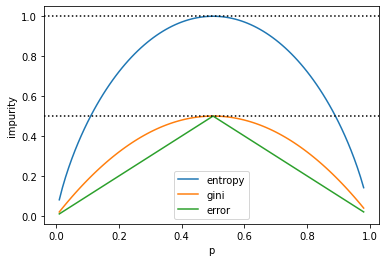

In [20]:
p = np.arange(0.01, 0.99, 0.01)
plt.plot(p, entropy(p), label='entropy')
plt.plot(p, gini(p), label='gini')
plt.plot(p, [error(pi) for pi in p], label='error')
# p값에 따른 entropy
# p값에 따른 gini
# p값에 따른 error
plt.axhline(y=1,c='k', linestyle=':')
plt.axhline(y=.5,c='k', linestyle=':')
plt.xticks()
plt.xlabel('p')
plt.ylabel('impurity')
plt.legend()
plt.show()

### **| 정보이득 (Information Gain)**

결정트리의 목적함수는 아래와 같습니다. 이 목적 함수는 각 분할이 정보 이득을 최대화 하도록 합니다. 

\begin{split}
IG(D_p, f) = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p}I(D_j)
\end{split}

\begin{split}
정보 이득  = (부모노드의 불순도) - 정규화된 (자식 노드의 불순도)
\end{split}

* $f$: 분할에 사용되는 특성(속성, 변수, feature)
* $D_p$ : 부모 노드의 데이터셋
* $D_j$ : j번째 자식 노드의 데이터셋
* $I$: 불순도
* $N_p$: 부모 노드의 전체 샘플개수
* $N_j$: j번째 자식 노드의 전체 샘플개수
* 정보이득이 높다 : 분할 결과가 좋다   1 - 0 (이상적)
* 정보이득이 낮다 : 분할 결과가 안좋다    1 - 0.9 (안좋다)

#### **예제 03**

다음 조건으로 분할이 진행되었을 때 정보이득을 계산하세요.

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DataAnalysis/blob/main/imgs/ch0510-01.PNG?raw=true
?raw=true width=750>
</p>

In [21]:
impurity = ['entropy', 'gini', 'error']
for i in impurity:
  p_p = 7/14 #부모노드 한쪽 클래스 확률
  i_p = np.round(eval(i)(p_p),2) # 부모노드 불순도
  p_1 = 3/4 # 자식노드1 한쪽 클래스 확률
  i_1 = np.round(eval(i)(p_1),2) # 자식1 노드 불순도
  p_2 = 4/10 # 자식노드2 한쪽 클래스 확률
  i_2 = np.round(eval(i)(p_2),2) # 자식 2 노드 불순도
  #information gain
  N_p, N_1, N_2 = 14, 4, 10 # 부모, 자식1, 자식2
  IG = i_p - (N_1/N_p)*i_1 - (N_1/N_p)*i_2
  IG = np.round(IG,2)
  print(f'{i}의 정보이득: {IG}')

entropy의 정보이득: 0.49
gini의 정보이득: 0.25
error의 정보이득: 0.31


#### **예제 04**

다음 A, B 조건으로 분할이 진행되었을 때 각각의 정보이득을 계산하고 어떤 분할이 더 적합한지 계산하세요.

<p align='center'>
<img src=https://camo.githubusercontent.com/c0c17de8d888513d12a1aa27c226d8e0e50a1ea02496719190899ce57ea5ca7a/68747470733a2f2f6769742e696f2f4a746d3244?raw=true
?raw=true width=600>
</p>

In [22]:
impurity = ['entropy', 'gini', 'error']
for i in impurity:
  p_p = 40/80 #부모노드 한쪽 클래스 확률
  i_p = np.round(eval(i)(p_p),2) # 부모노드 불순도
  p_1 = 30/40 # 자식노드1 한쪽 클래스 확률
  i_1 = np.round(eval(i)(p_1),2) # 자식1 노드 불순도
  p_2 = 10/40 # 자식노드2 한쪽 클래스 확률
  i_2 = np.round(eval(i)(p_2),2) # 자식 2 노드 불순도
  #information gain
  N_p, N_1, N_2 = 80, 40, 40 # 부모, 자식1, 자식2
  IG = i_p - (N_1/N_p)*i_1 - (N_1/N_p)*i_2
  IG = np.round(IG,2)
  print(f'{i}의 정보이득: {IG}')

entropy의 정보이득: 0.19
gini의 정보이득: 0.12
error의 정보이득: 0.25


In [23]:
impurity = ['entropy', 'gini', 'error']
for i in impurity:
  p_p = 40/80 #부모노드 한쪽 클래스 확률
  i_p = np.round(eval(i)(p_p),2) # 부모노드 불순도
  p_1 = 20/60 # 자식노드1 한쪽 클래스 확률
  i_1 = np.round(eval(i)(p_1),2) # 자식1 노드 불순도
  p_2 = 20/20 # 자식노드2 한쪽 클래스 확률
  i_2 = np.round(eval(i)(p_2),2) # 자식 2 노드 불순도
  #information gain
  N_p, N_1, N_2 = 80, 60, 20 # 부모, 자식1, 자식2
  IG = i_p - (N_1/N_p)*i_1 - (N_1/N_p)*i_2
  IG = np.round(IG,2)
  print(f'{i}의 정보이득: {IG}')

entropy의 정보이득: nan
gini의 정보이득: 0.17
error의 정보이득: 0.25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


# B조건이 정보이득이 더 높다

### | 사이킷런을 이용한 구현

[사이킷런 - DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier)
```
tree.DecisionTreeClassifier(*, criterion='gini', #불순도 지표 선택(gini)가 default
                           splitter='best', 
                           max_depth=None,   #최대 트리 깊이
                           min_samples_split=2, 
                           min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0,
                           max_features=None, 
                           random_state=None, 
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           class_weight=None, 
                           ccp_alpha=0.0)
```

* 'petal' 관련 특성으로 3개 멀티클래스 분류
* 모델
  * 지니 불순도 사용
  * 최대 트리 깊이 5
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화
  * 결정트리 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


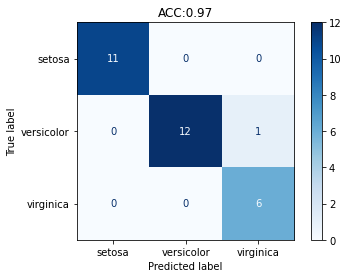

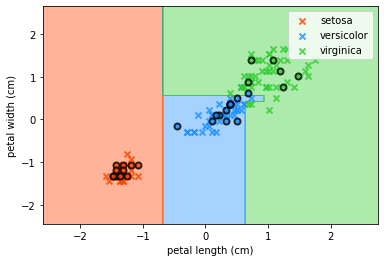

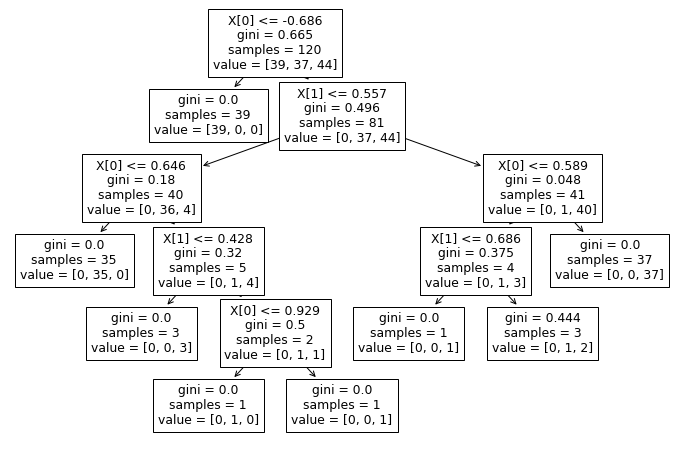

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')

# 학습
model = DecisionTreeClassifier(criterion='gini',
                              max_depth=5)
model.fit(X_train, y_train)

# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
plt.show()

# 결정경계 시각화
draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
plt.show()

# 트리 시각화
plt.figure(figsize=(12,8))
plot_tree(model)
plt.show()

#### **예제 05**

* 'sepal' 관련 특성으로 3개 멀티클래스 분류
* 모델
  * 지니 불순도 사용
  * 최대 트리 깊이 4
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화
  * 결정트리 시각화


(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


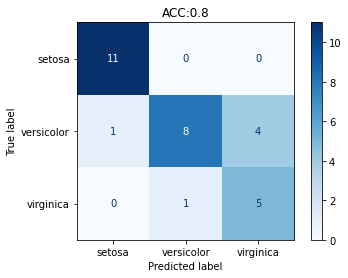

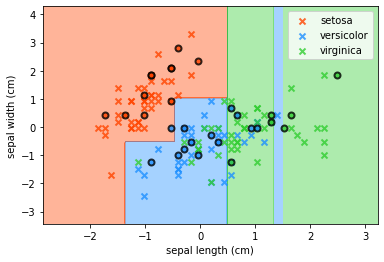

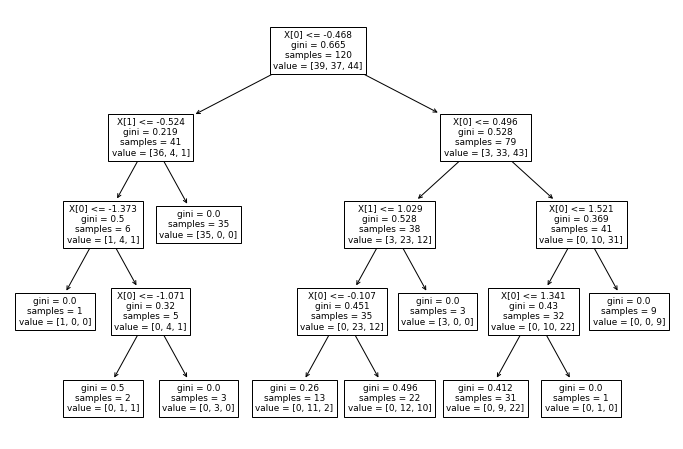

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')

# 학습
model = DecisionTreeClassifier(criterion='gini',
                              max_depth=4)
model.fit(X_train, y_train)

# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
plt.show()

# 결정경계 시각화
draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
plt.show()

# 트리 시각화
plt.figure(figsize=(12,8))
plot_tree(model)
plt.show()

#### **예제 06**

* 'sepal' 관련 특성으로  3개 멀티클래스 분류
* 모델
  * 엔트로피 불순도 사용
  * 최대 트리 깊이 3
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화
  * 결정트리 시각화

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


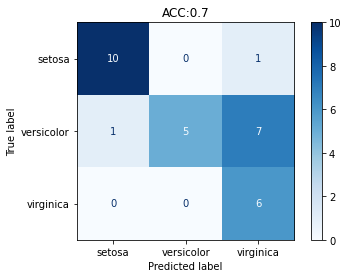

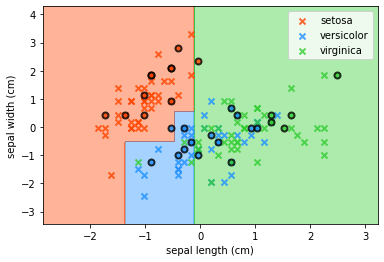

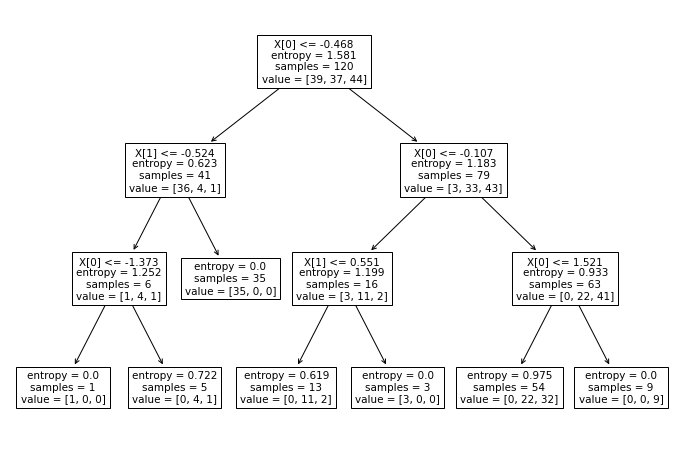

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')

# 학습
model = DecisionTreeClassifier(criterion='entropy',
                              max_depth=3)
model.fit(X_train, y_train)

# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
plt.show()

# 결정경계 시각화
draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
plt.show()

# 트리 시각화
plt.figure(figsize=(12,8))
plot_tree(model)
plt.show()

## 서포트 벡터 머신 (Support Vector Machine)
---

서포트 벡터 머신(Support Vector Machine, SVM)은 강력하고 널리 사용되는 학습 알고리즘으로, 퍼셉트론 계열의 알고리즘을 확장 시킨 개념으로 생각 할 수 있다.

* 퍼셉트론의 아이디어: 분류 오차의 최소화
* 서포트 벡터 머신의 아이디어: 마진(margine)의 최대화

이 때 마진은 결정 경계(초평면)과 초평면에 가장 가까운 훈련 샘플 사이 거리로 정의

이 때 가장 가까운 샘플을 서포트 벡터(support vector)라 한다.


<p align='center'>
<img src=https://camo.githubusercontent.com/c63b819ba8417477499bd6b7017f4433d7362f1bbfab22035ce37ab6e4889b1b/68747470733a2f2f6769742e696f2f4a746d3272
?raw=true width=800>
</p>







### **| 제약 조건**
---
- 모든 샘플이 정확하게 분류 되었을 때, 

\begin{split}
w_o + w^Tx^{(i)} \geq 1 
\\
w_o + w^Tx^{(i)} \leq -1 
\end{split}


### **| 목적 함수** 
---
- 마진(margin)을 최대화

\begin{split}
\frac{w^T(x_{pos}-x_{neg})}{||w||_2}=\frac{2}{||w||_2}
\end{split}


### | 사이킷런을 이용한 구현

[사이킷런 - SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
```
svm.SVC(C=1.0,  # weight규제 강도
        kernel='rbf',  # {rbf: 가우시안, linear: 직선, poly,  sigmoid}
        degree=3, 
        gamma='scale', # kernel = rbf라면 가우시안 구의 크기 제한 (규제)
        coef0=0.0, 
        shrinking=True, 
        probability=False, 
        tol=0.001, 
        cache_size=200, 
        class_weight=None, 
        verbose=False, 
        max_iter=- 1, 
        decision_function_shape='ovr', 
        break_ties=False, 
        random_state=None)
```

* 'petal' 관련 특성으로  멀티클래스 분류
* 모델
  * `kernel` = 'linear'
  * `C` = 1
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


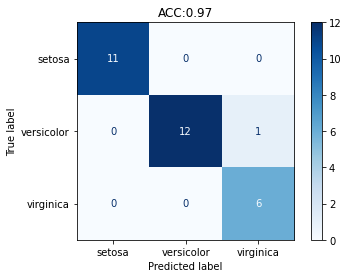

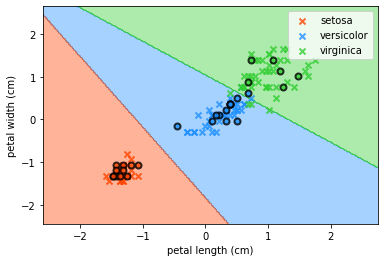

In [27]:
from sklearn.svm import SVC

# 데이터 준비
X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')


# 학습
model = SVC(C=1, kernel='linear')
model.fit(X_train, y_train)


# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
plt.show()

# 결정경계 시각화
draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
plt.show()


#### **예제 07**

* 'sepal' 관련 특성으로  3개 멀티클래스 분류
* 모델
  * `kernel` = 'linear'
  * `C` = 0.01, 0.1, 1, 10, 100 일때, 각각에 대한 모델 학습 및 평가
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


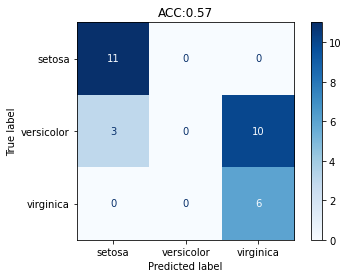

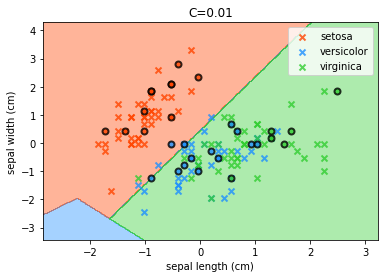

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


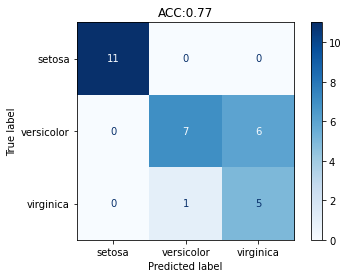

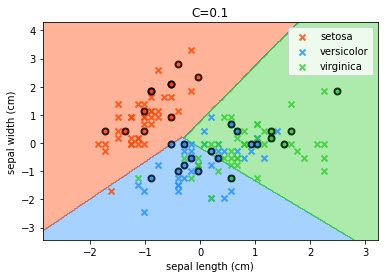

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


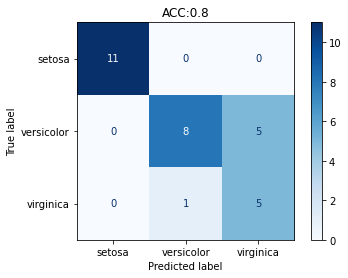

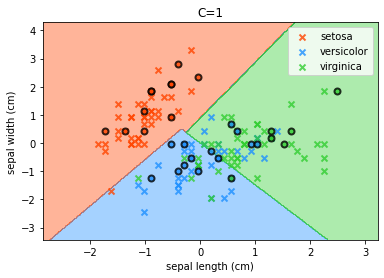

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


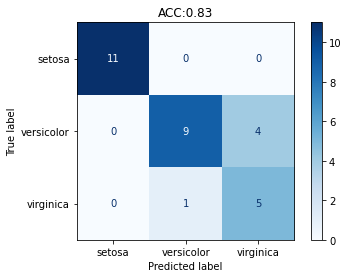

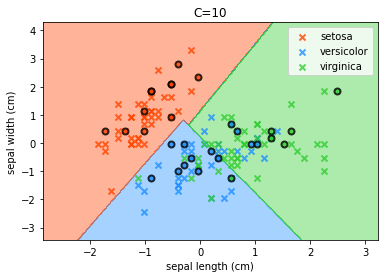

(120, 2) (30, 2) (120,) (30,) sepal ['setosa' 'versicolor' 'virginica']


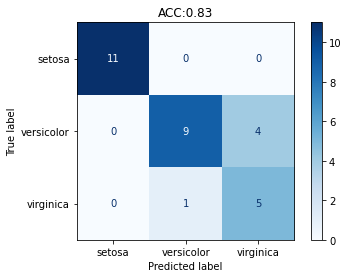

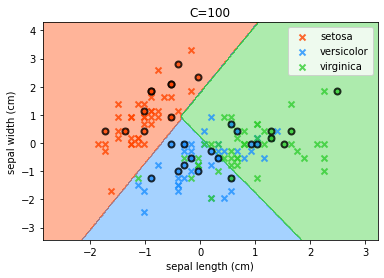

In [28]:
from sklearn.svm import SVC

for C in [0.01,0.1,1,10,100]:
  # 데이터 준비
  X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'sepal')


  # 학습
  model = SVC(C=C, kernel='linear')
  model.fit(X_train, y_train)


  # 정확도 출력 및 혼돈행렬 시각화
  acc = model.score(X_test, y_test)
  draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
  plt.show()

  # 결정경계 시각화
  draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
  plt.title(f'C={C}')
  plt.show()


### **| 커널 SVM**

* 'petal' 관련 특성으로  멀티클래스 분류
* 모델
  * `kernel` = 'linear', 'poly', 'rbf', 'sigmoid' 일 때, 각각에 대한 모델 학습 및 평가
* 평가
  * 정확도 계산
  * 혼돈행렬 시각화
  * 결정경계 시각화

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


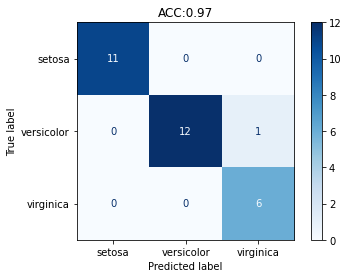

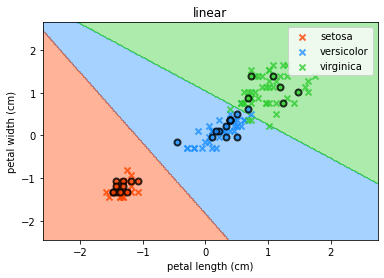

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


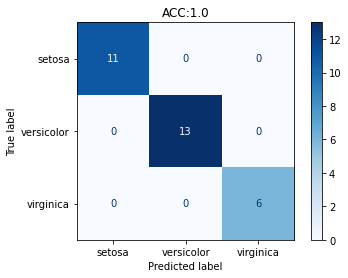

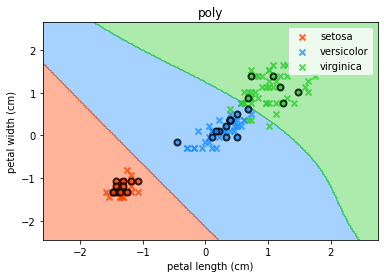

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


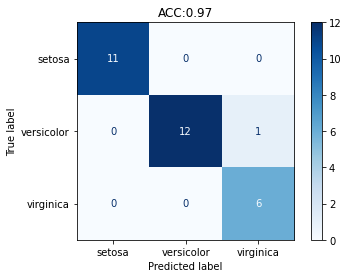

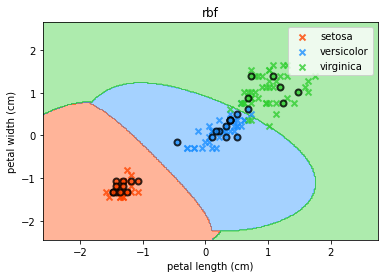

(120, 2) (30, 2) (120,) (30,) petal ['setosa' 'versicolor' 'virginica']


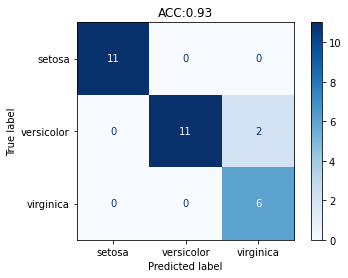

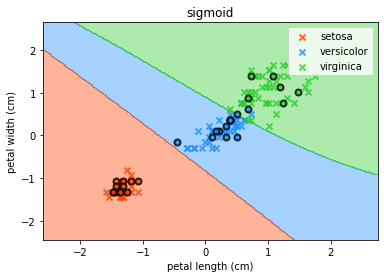

In [29]:
from sklearn.svm import SVC

for kernel in ['linear', 'poly', 'rbf', 'sigmoid' ]:
  # 데이터 준비
  X_train, X_test, y_train, y_test, columns, labels = iris_loader(3, 'petal')


  # 학습
  model = SVC(C=1, kernel=kernel)
  model.fit(X_train, y_train)


  # 정확도 출력 및 혼돈행렬 시각화
  acc = model.score(X_test, y_test)
  draw_cm(model, X_test, y_test, title=f'ACC:{np.round(acc,2)}')
  plt.show()

  # 결정경계 시각화
  draw_decision_region(model, X_train, y_train, X_test, y_test, features=columns, labels=labels)
  plt.title(kernel)
  plt.show()


### **| XOR 문제 풀기**




* 데이터 생성


```
np.random.seed(5)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0]>0, X_xor[:,1]>0)
y_xor = np.where(y_xor, 1, 0)
```

(200, 2) (200,)


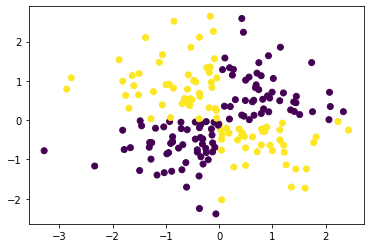

In [30]:
np.random.seed(5)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0]>0, X_xor[:,1]>0)
y_xor = np.where(y_xor, 1, 0)
print(X_xor.shape, y_xor.shape)
# x=속성1 y=속성2 색깔을 클래스로 구분(0,1)
plt.scatter(X_xor[:,0], X_xor[:,1], c=y_xor)

* kernel =  ['linear', 'poly', 'rbf', 'sigmoid'] 각각에 대해 결정경계 시각화

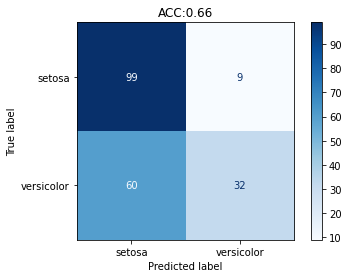

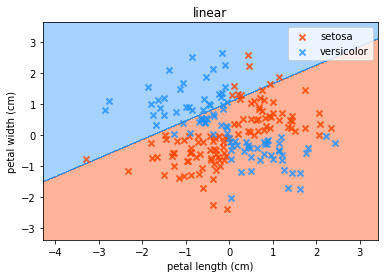

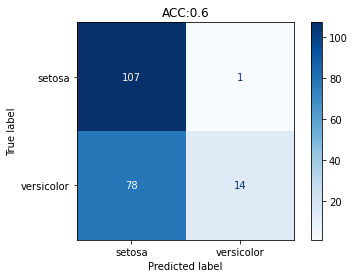

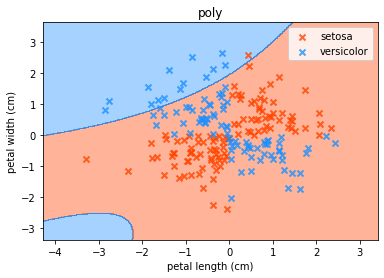

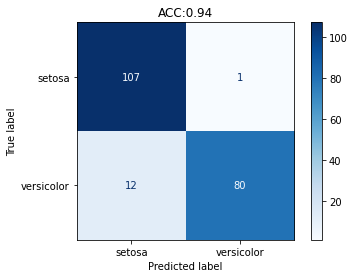

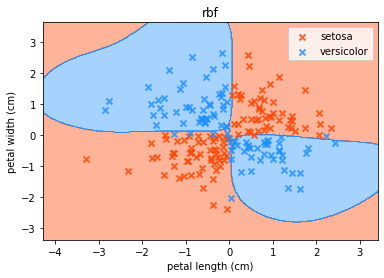

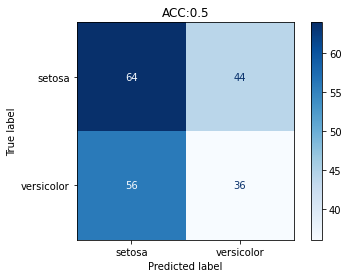

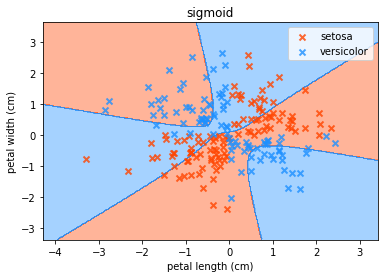

In [31]:
from sklearn.svm import SVC

for kernel in ['linear', 'poly', 'rbf', 'sigmoid' ]:
  # 학습
  model = SVC(C=1, kernel=kernel)
  model.fit(X_xor, y_xor)


  # 정확도 출력 및 혼돈행렬 시각화
  acc = model.score(X_xor, y_xor)
  draw_cm(model, X_xor, y_xor, title=f'ACC:{np.round(acc,2)}')
  plt.show()

  # 결정경계 시각화
  draw_decision_region(model, X_xor, y_xor, features=columns, labels=labels)
  plt.title(kernel)
  plt.show()


#### **`gamma` 값 조절하여 과적합 개념 이해하기**

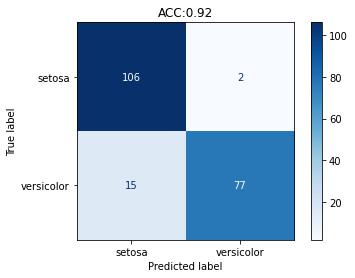

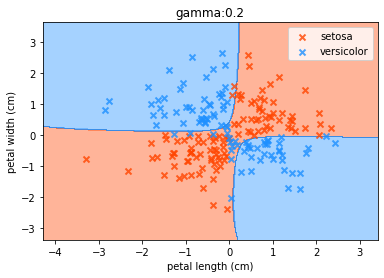

In [32]:
from sklearn.svm import SVC

# kernel = rbf : gamma = 0.01, 0.1, 1, 10, 100
for gamma in [0.2]:
  # 학습
  model = SVC(C=1, kernel='rbf', gamma=gamma)
  model.fit(X_xor, y_xor)


  # 정확도 출력 및 혼돈행렬 시각화
  acc = model.score(X_xor, y_xor)
  draw_cm(model, X_xor, y_xor, title=f'ACC:{np.round(acc,2)}')
  plt.show()

  # 결정경계 시각화
  draw_decision_region(model, X_xor, y_xor, features=columns, labels=labels)
  plt.title(f'gamma:{gamma}')
  plt.show()


#### **규제를 사용하여 과대적합 피하기**

* Regularization: 파라미터 값이 과도해지는 것을 제한하기 위한 추가 항


$J(w) = \sum_i^n[-y^{(i)}log(\sigma(z^{(i)}))-(1-y^{(i)})log(1-\sigma(z^{(i)}))]+\frac{\lambda}{2}||w||^2$

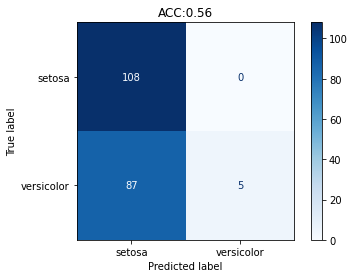

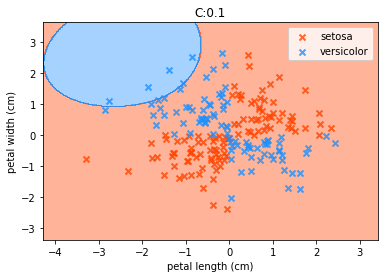

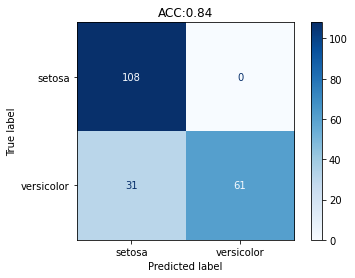

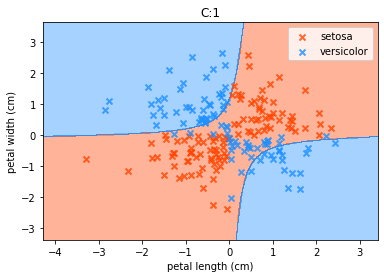

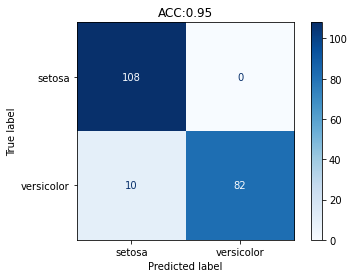

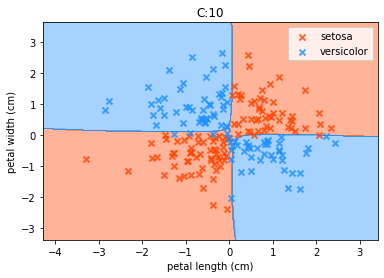

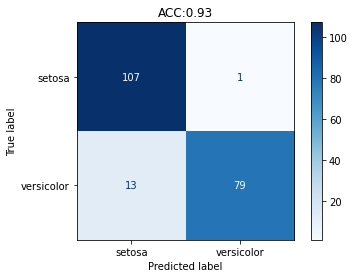

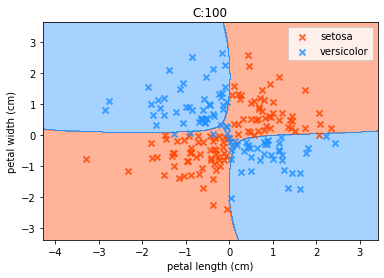

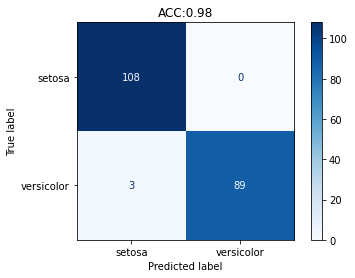

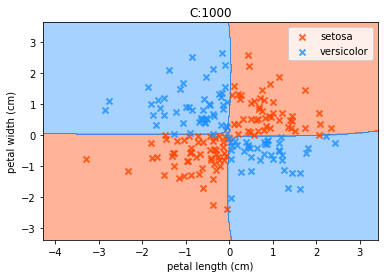

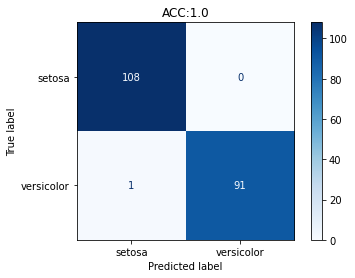

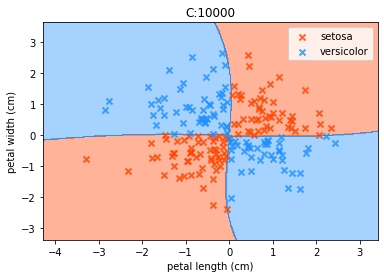

In [33]:
from sklearn.svm import SVC

# kernel = rbf , gamma = 0.2, C=[0.1, 1, 10 ,100, 1000, 10000]
for C in [0.1, 1, 10 ,100, 1000, 10000]:
  # 학습
  model = SVC(C=C, kernel='rbf', gamma=0.1)
  model.fit(X_xor, y_xor)


  # 정확도 출력 및 혼돈행렬 시각화
  acc = model.score(X_xor, y_xor)
  draw_cm(model, X_xor, y_xor, title=f'ACC:{np.round(acc,2)}')
  plt.show()

  # 결정경계 시각화
  draw_decision_region(model, X_xor, y_xor, features=columns, labels=labels)
  plt.title(f'C:{C}')
  plt.show()


* 적절한 하이퍼 파라미터 적용

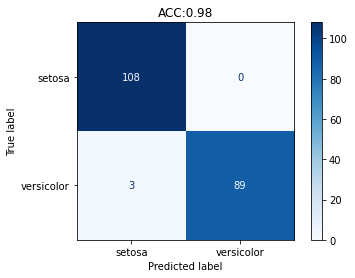

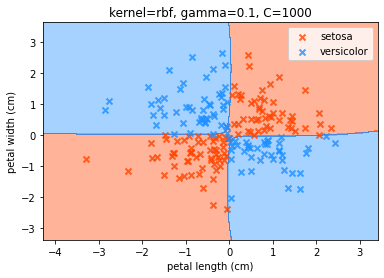

In [34]:
from sklearn.svm import SVC

# kernel = rbf , gamma = 0.1, C=1000
# 학습
model = SVC(C=1000, kernel='rbf', gamma=0.1)
model.fit(X_xor, y_xor)
# 정확도 출력 및 혼돈행렬 시각화
acc = model.score(X_xor, y_xor)
draw_cm(model, X_xor, y_xor, title=f'ACC:{np.round(acc,2)}')
plt.show()
# 결정경계 시각화
draw_decision_region(model, X_xor, y_xor, features=columns, labels=labels)
plt.title(f'kernel=rbf, gamma=0.1, C=1000')
plt.show()


## **과제1: 펭귄데이터셋 분류**
---
```
df = sns.load_dataset('penguins')
df.shape
```
* 펭귄데이터셋을 불러오고 간단히 전처리 후 멀티클래스 분류를 진행합니다.
* 세 종류의 알고리즘을 사용해 보세요
* 각 알고리즘의 하이퍼파라미터를 조정해 가며 성능을 비교해 보세요.

In [35]:
import seaborn as sns
df = sns.load_dataset('penguins')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [36]:
df.dropna(axis=0, subset=['sex'], inplace=True)

In [37]:
X = df.iloc[:,1:]
y = df['species']

In [38]:
y.replace('Adelie',0, inplace=True)
y.replace('Chinstrap',1, inplace=True)
y.replace('Gentoo',2, inplace=True)

In [39]:
X.replace('Biscoe',0,inplace=True)
X.replace('Torgersen',1,inplace=True)
X.replace('Dream',2,inplace=True)

In [40]:
X.replace('Male',0,inplace=True)
X.replace('Female',1,inplace=True)

In [41]:
y.unique()

array([0, 1, 2])

In [42]:
columns = ['island',	'bill_length_mm',	'bill_depth_mm',	'flipper_length_mm',	'body_mass_g',	'sex'] 
labels = ['Adelie','Chinstrap','Gentoo']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266, 6), (67, 6), (266,), (67,))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


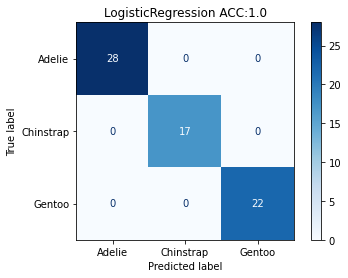

In [43]:
# LogisticRegression
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, y_train)
acc = LR.score(X_test, y_test)
draw_cm(LR, X_test, y_test, title=f'LogisticRegression ACC:{np.round(acc,2)}')
plt.show()

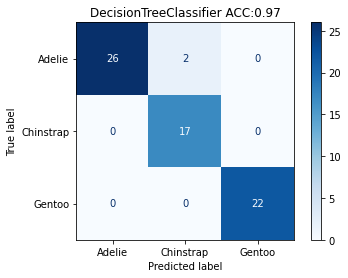

In [44]:
# DecisionTreeClassifier
DTC = DecisionTreeClassifier(criterion='gini', max_depth=4)
DTC.fit(X_train, y_train)
acc = DTC.score(X_test, y_test)
draw_cm(DTC, X_test, y_test, title=f'DecisionTreeClassifier ACC:{np.round(acc,2)}')
plt.show()

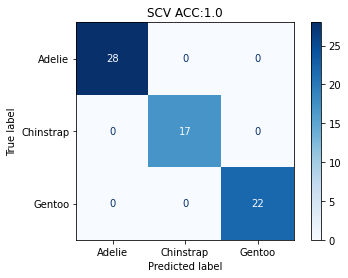

In [45]:
# SVC
model = SVC(C=1000, kernel='poly', gamma=0.1)
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
draw_cm(model, X_test, y_test, title=f'SCV ACC:{np.round(acc,2)}')
plt.show()

## **과제2: 타이타닉 : 누가 살아남았을까?**
---

* https://dacon.io/competitions/open/235539/data
* 수업 시간에 배운 내용들을 적용하여 이진분류를 진행하고 리더보드에 결과를 제출합니다.
* 평가 지표는 AUC 이지만 아직 배우지 않은 내용이므로, 우선 정확도로 평가하세요

In [47]:
import pandas as pd

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/submission.csv')

In [48]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
train['Fare'] = np.round(train['Fare'])
test['Fare'] = np.round(train['Fare'])

In [51]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [52]:
print(train.isnull().mean()*100) #결측치 비율
print(test.isnull().mean()*100) #결측치 비율

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [53]:
train.drop(['Cabin','PassengerId','Name','Ticket'], axis=1, inplace=True)
test.drop(['Cabin','PassengerId','Name','Ticket'], axis=1, inplace=True)

In [54]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)

In [55]:
train.dropna(axis=0, subset=['Embarked'], inplace=True)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

In [56]:
train['Sex'].replace('male',0,inplace=True)
train['Sex'].replace('female',1,inplace=True)

test['Sex'].replace('male',0,inplace=True)
test['Sex'].replace('female',1,inplace=True)

In [57]:
for col in ['Embarked','Fare']:
  print(train[col].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
8.0      206
7.0       65
26.0      46
13.0      46
10.0      43
        ... 
212.0      1
75.0       1
76.0       1
63.0       1
5.0        1
Name: Fare, Length: 90, dtype: int64


In [58]:
train['Embarked'].replace('S',0,inplace=True)
train['Embarked'].replace('C',1,inplace=True)
train['Embarked'].replace('Q',2,inplace=True)

test['Embarked'].replace('S',0,inplace=True)
test['Embarked'].replace('C',1,inplace=True)
test['Embarked'].replace('Q',2,inplace=True)

In [59]:
columns = ['Pclass',	'Sex',	'Age', 'SibSp',	'Parch',	'Fare',	'Embarked'] 
labels = ['die','alive']
X = train.iloc[:, 1:].values
y = train.iloc[:, :1].values
X_test = test.values

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=1)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((711, 7), (178, 7), (711, 1), (178, 1))

In [60]:
from sklearn.preprocessing import StandardScaler # 평균0 편차 1인 

sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_valid = sc_x.transform(X_valid)
X_test = sc_x.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


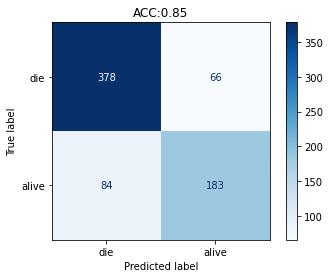

In [418]:
model = LogisticRegression(solver='newton-cg', penalty='l2')
model.fit(X_train, y_train)
acc = model.score(X_valid, y_valid)
draw_cm(model, X_train, y_train, title=f'ACC:{np.round(acc,2)}')

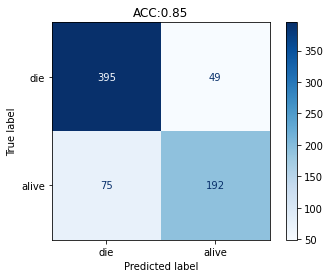

In [64]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X_train, y_train)
acc = model.score(X_valid, y_valid)
draw_cm(model, X_train, y_train, title=f'ACC:{np.round(acc,2)}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


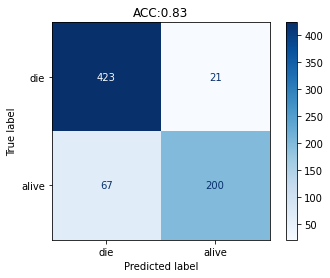

In [69]:
model = SVC(C=1, kernel='rbf', gamma=1)
model.fit(X_train, y_train)
acc = model.score(X_valid, y_valid)
draw_cm(model, X_train, y_train, title=f'ACC:{np.round(acc,2)}')

In [74]:
y_pred = model.predict(X_test) #DecisionTreeClassifier로 학습

In [75]:
submission['Survived'] = y_pred

In [76]:
submission.to_csv('submission.csv', index = False)